In [2]:
# import
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [4]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

In [5]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
def get_market_exit_signal(index_data, long_term_ma):
    index_data['Long_Term_MA'] = index_data['Close'].rolling(window=long_term_ma).mean()
    if index_data['Close'].iloc[-1] < index_data['Long_Term_MA'].iloc[-1]:
        return "Exit Market"
    return "Stay"
def check_buy_signal(stock_data, short_window=5, long_window=20, rsi_buy_signal=40):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for buy signal
    buy_signal = (stock_data['Short_MA'].iloc[-1] < stock_data['Long_MA'].iloc[-1]) and \
                 (stock_data['RSI'].iloc[-1] < rsi_buy_signal) and \
                 (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return buy_signal

def check_sell_signal(stock_data, short_window=5, long_window=20, rsi_sell_signal=90):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for sell signal
    sell_signal = (stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1]) and \
                  (stock_data['RSI'].iloc[-1] > rsi_sell_signal) and \
                  (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return sell_signal

In [7]:
def decide_trade(stock_data, short_window, long_window, rsi_buy_signal=40, rsi_sell_signal=90):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    buy_signals = (stock_data['Short_MA'] < stock_data['Long_MA']) & (stock_data['RSI'] < rsi_buy_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    sell_signals = (stock_data['Short_MA'] > stock_data['Long_MA']) & (stock_data['RSI'] > rsi_sell_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    
    return buy_signals, sell_signals

In [8]:
def recommended_pe_ratio(sector):
    pe_ratios = {
        'Technology': (25, 35),
        'Utilities': (10, 20),
        'Consumer Discretionary': (15, 25),
        'Healthcare': (15, 25),
        'Pharmaceuticals': (15, 25),
        'Financial': (10, 15),
        'Energy': (5, 15),
        'Industrials': (15, 25),
        'Materials': (15, 25),
        'Real Estate': (15, 25),
        'Telecommunication': (10, 15),
        'Consumer Staples': (20, 25),
        'Information Technology': (25, 35)
    }
    
    return pe_ratios.get(sector, ('N/A', 'N/A'))  # Default to 'N/A' if the sector is not listed

# Example usage
sector = 'Technology'
print(f"Recommended P/E Ratio for {sector}: {recommended_pe_ratio(sector)}")

Recommended P/E Ratio for Technology: (25, 35)


In [111]:
def backtest_strategy(stock_data, buy_signals, sell_signals, holding_period=30, investment_fraction=0.1):
    initial_balance = 10000  # Example starting balance
    balance = initial_balance
    position = 0
    purchase_price = 0  # To track the purchase price of the stock
    holding_start_date = None  # To track when a stock is bought
    trade_history = []

    for i in range(len(stock_data)):
        current_date = stock_data.index[i]
        current_price = stock_data['Close'][i]

        if buy_signals[i] and balance >= current_price:
            # Buy - use only a fraction of the available balance
            investment_amount = balance * investment_fraction
            shares_to_buy = investment_amount // current_price
            if shares_to_buy > 0:  # Ensuring we have enough balance to buy at least one share
                balance -= shares_to_buy * current_price
                position += shares_to_buy
                purchase_price = current_price
                holding_start_date = current_date
                trade_history.append(('BUY', current_date, current_price, shares_to_buy))

        elif sell_signals[i] and position > 0:
            days_held = (current_date - holding_start_date).days if holding_start_date else 0
            is_profit = current_price > purchase_price

            # Sell if held for at least 30 days or at a loss
            if days_held >= holding_period or not is_profit:
                balance += position * current_price
                trade_history.append(('SELL', current_date, current_price, position))
                position = 0
                holding_start_date = None
                purchase_price = 0

    final_balance = balance + (position * stock_data['Close'].iloc[-1])
    total_return = final_balance - initial_balance
    return_percentage = (total_return / initial_balance) * 100

    return trade_history, total_return, return_percentage

[*********************100%%**********************]  1 of 1 completed

Analyzing 601288.SS...
Buy signals for 601288.SS:
             Open  High   Low  Close  Adj Close     Volume  Short_MA  Long_MA  \
Date                                                                           
2022-03-08  2.97  2.98  2.96   2.97   2.592276  337625505     2.990   3.0160   
2022-03-09  2.97  2.98  2.93   2.94   2.566091  436928509     2.978   3.0105   
2022-05-30  3.04  3.04  3.02   3.02   2.635916  360547459     3.032   3.0415   
2022-07-29  2.86  2.86  2.83   2.85   2.675063  230825942     2.852   2.9170   
2022-08-02  2.83  2.84  2.80   2.81   2.637519  297661384     2.838   2.8970   
2022-10-27  2.83  2.83  2.78   2.80   2.628133  581566465     2.838   2.8490   
2022-11-01  2.77  2.77  2.71   2.73   2.562429  853481093     2.784   2.8355   
2022-11-10  2.74  2.77  2.73   2.76   2.590588  334545512     2.748   2.7950   
2023-08-21  3.51  3.51  3.42   3.43   3.430000  317558713     3.474   3.5155   
2023-12-06  3.61  3.61  3.53   3.53   3.530000  516995691     3.618  

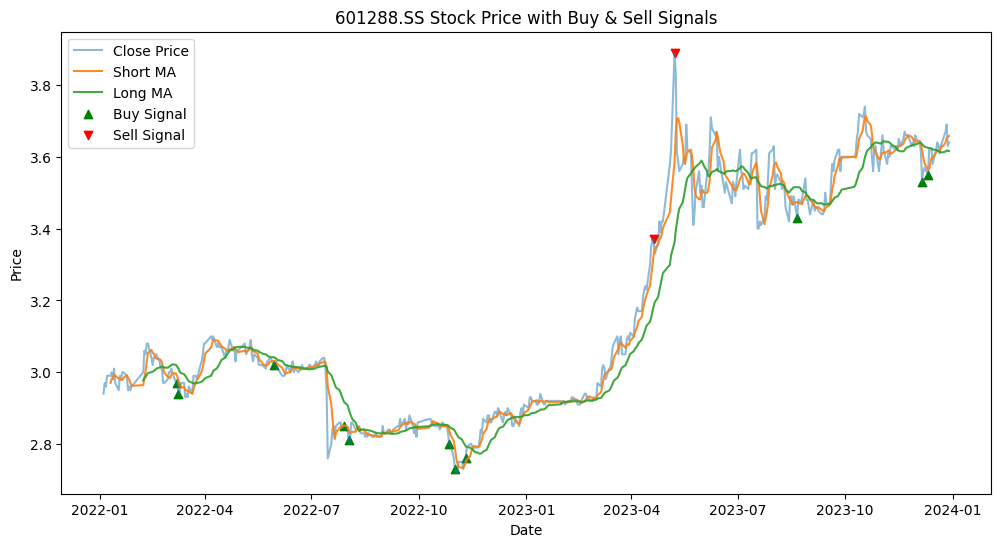

[*********************100%%**********************]  1 of 1 completed

Analyzing 688091.SS...
Buy signals for 688091.SS:
                   Open        High        Low       Close   Adj Close  \
Date                                                                    
2022-07-12  108.288773  108.288773  99.465240  102.272728  101.925934   
2022-07-15  100.274063  103.141708  96.229942   96.336899   96.010239   
2022-07-28   92.045456   94.237968  88.529411   92.647057   92.332901   
2022-07-29   92.647057   95.026733  88.228607   89.425133   89.121902   
2022-08-02   89.244652   91.878342  86.430481   87.500000   87.203300   
2022-08-24   75.902405   76.203209  70.969254   71.069519   70.828529   
2022-09-05   67.593582   77.419785  67.593582   72.259361   72.014343   
2022-09-06   72.586899   75.354279  70.320854   73.923798   73.673134   
2022-09-26   60.026737   64.625671  59.358288   62.279411   62.068230   
2022-09-27   62.352940   65.073532  61.744652   63.442513   63.227390   
2022-09-28   63.502674   64.839569  62.192513   62.386364   62.174820   


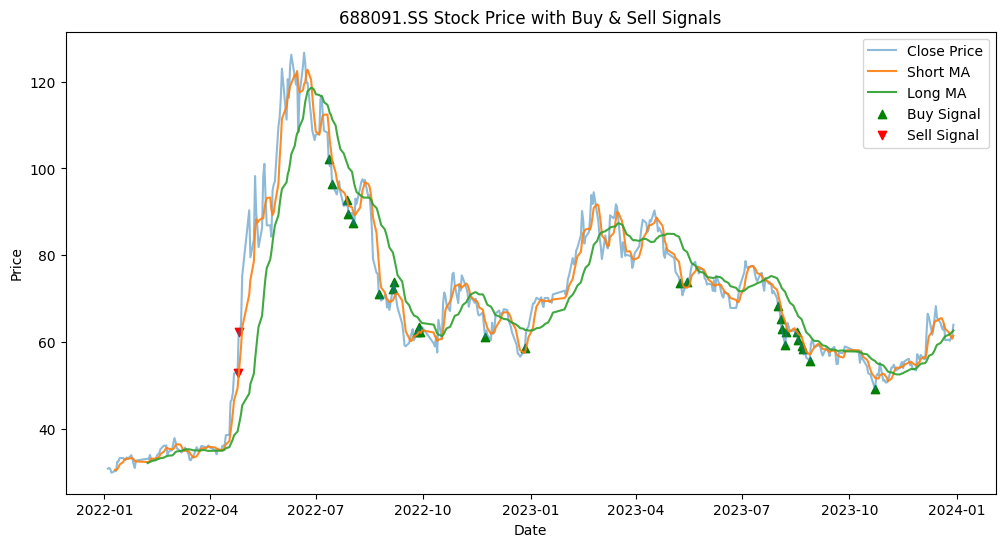

[*********************100%%**********************]  1 of 1 completed

Analyzing 600221.SS...
Buy signals for 600221.SS:
             Open  High   Low  Close  Adj Close     Volume  Short_MA  Long_MA  \
Date                                                                           
2022-03-15  1.84  1.85  1.81   1.81       1.81  100187177     1.852   1.9300   
2022-03-22  1.79  1.84  1.79   1.83       1.83   97854138     1.842   1.8955   
2022-04-11  1.79  1.80  1.71   1.72       1.72  100934704     1.788   1.8195   
2022-04-21  1.72  1.73  1.66   1.68       1.68   80067805     1.728   1.7820   
2022-06-10  1.64  1.65  1.63   1.64       1.64   54477973     1.656   1.6725   
2022-06-13  1.63  1.64  1.60   1.61       1.61   89975534     1.646   1.6690   
2022-06-14  1.60  1.60  1.57   1.59       1.59   69788081     1.630   1.6650   
2022-06-27  1.60  1.63  1.59   1.60       1.60  111177314     1.602   1.6290   
2022-07-11  1.51  1.51  1.48   1.48       1.48   73439029     1.514   1.5745   
2022-07-12  1.48  1.48  1.45   1.46       1.46   74534304     1.496  

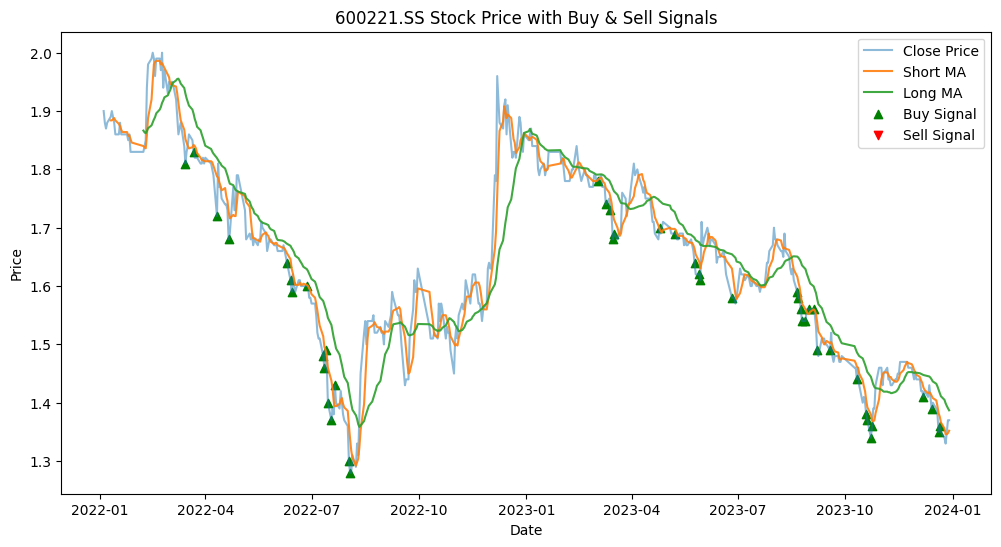

[*********************100%%**********************]  1 of 1 completed

Analyzing 600733.SS...
Buy signals for 600733.SS:
             Open  High   Low  Close  Adj Close     Volume  Short_MA  Long_MA  \
Date                                                                           
2022-03-08  8.37  8.46  7.89   7.92       7.92   59790134     8.568   9.0250   
2022-03-09  7.95  7.99  7.30   7.70       7.70   62033269     8.292   8.9640   
2022-03-15  7.53  7.63  7.13   7.13       7.13   52913588     7.638   8.6725   
2022-03-16  7.29  7.44  6.95   7.44       7.44   61346340     7.586   8.5835   
2022-03-17  7.51  7.63  7.44   7.44       7.44   52481768     7.512   8.4885   
2022-03-25  7.21  7.26  7.01   7.03       7.03   42589333     7.292   7.9075   
2022-07-15  8.50  8.82  8.32   8.32       8.32  115859094     8.530   9.2360   
2022-07-28  8.12  8.21  8.03   8.07       8.07   54173924     8.150   8.7020   
2022-09-16  7.07  7.09  6.77   6.77       6.77   41586184     7.226   7.5780   
2022-09-19  6.75  6.96  6.73   6.79       6.79   41391876     7.100  

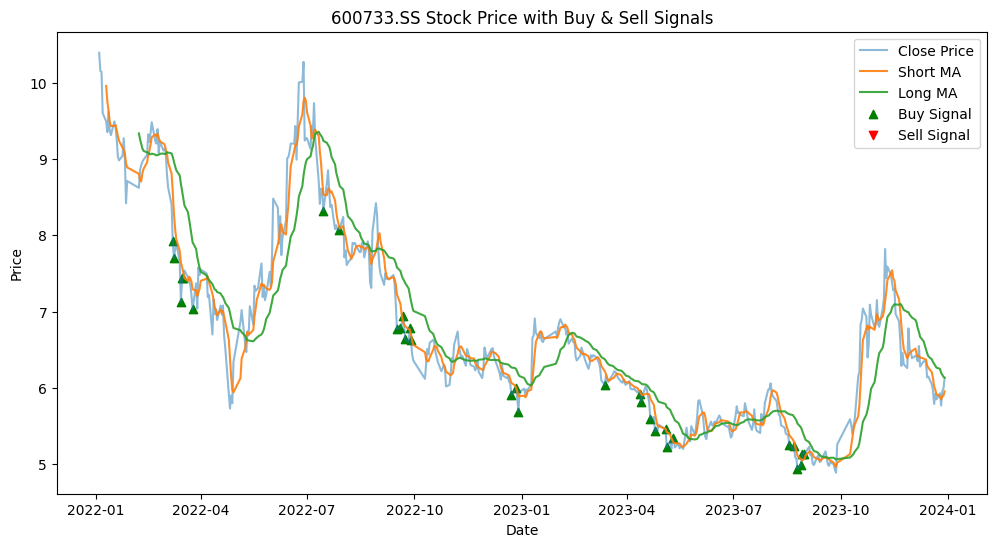

[*********************100%%**********************]  1 of 1 completed


Analyzing 300169.SZ...
Buy signals for 300169.SZ:
             Open  High   Low  Close  Adj Close    Volume  Short_MA  Long_MA  \
Date                                                                          
2022-03-08  5.67  5.71  5.51   5.55       5.55   4450164     5.780   5.9950   
2022-03-09  5.60  5.60  5.20   5.40       5.40   5428528     5.662   5.9560   
2022-03-10  5.48  5.63  5.47   5.50       5.50   4703081     5.580   5.9230   
2022-03-15  5.37  5.40  5.03   5.06       5.06   4340841     5.382   5.8160   
2022-04-15  4.95  4.95  4.79   4.79       4.79   3876507     4.942   5.2665   
2022-04-20  4.78  4.93  4.73   4.75       4.75   3494400     4.818   5.1560   
2022-04-21  4.73  4.76  4.53   4.55       4.55   3265610     4.740   5.1060   
2022-04-25  4.40  4.56  4.10   4.10       4.10   4667900     4.546   4.9895   
2022-04-26  4.11  4.19  3.94   3.95       3.95   4150700     4.374   4.9155   
2022-04-27  3.94  4.03  3.79   4.00       4.00   5101300     4.224   4.8470   
2

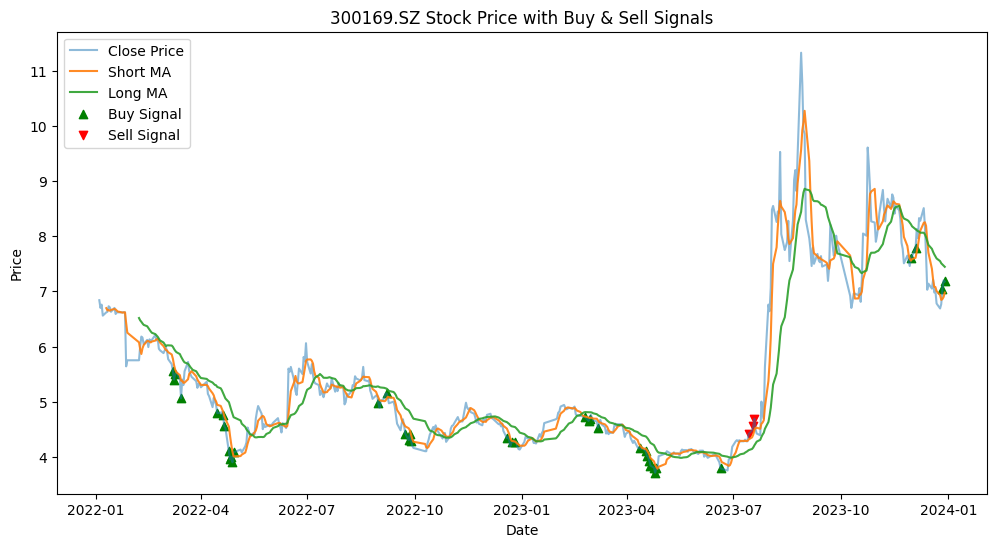

Analyzing 603628.SS...


[*********************100%%**********************]  1 of 1 completed


Buy signals for 603628.SS:
                  Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2022-04-11  11.660000  11.660000  10.850000  10.950000  10.863590   3681800   
2022-04-15  10.800000  10.800000  10.430000  10.470000  10.387379   3157800   
2022-04-18  10.450000  10.880000  10.150000  10.880000  10.794144   3138400   
2022-04-19  10.900000  11.200000  10.850000  11.090000  11.002486   3725900   
2022-04-25   9.940000   9.940000   8.980000   8.980000   8.909137   3575166   
2022-04-26   8.980000   9.160000   8.440000   8.500000   8.432924   2840266   
2022-04-27   8.390000   8.950000   8.220000   8.940000   8.869452   2912877   
2022-09-08  16.129999  16.799999  15.800000  16.139999  16.055107  11952315   
2022-09-15  15.480000  15.490000  14.000000  14.300000  14.224787   9199215   
2022-12-22  16.110001  16.290001  14.550000  14.780000  14.702262   7793220   
2022-12-23  14.780000  1

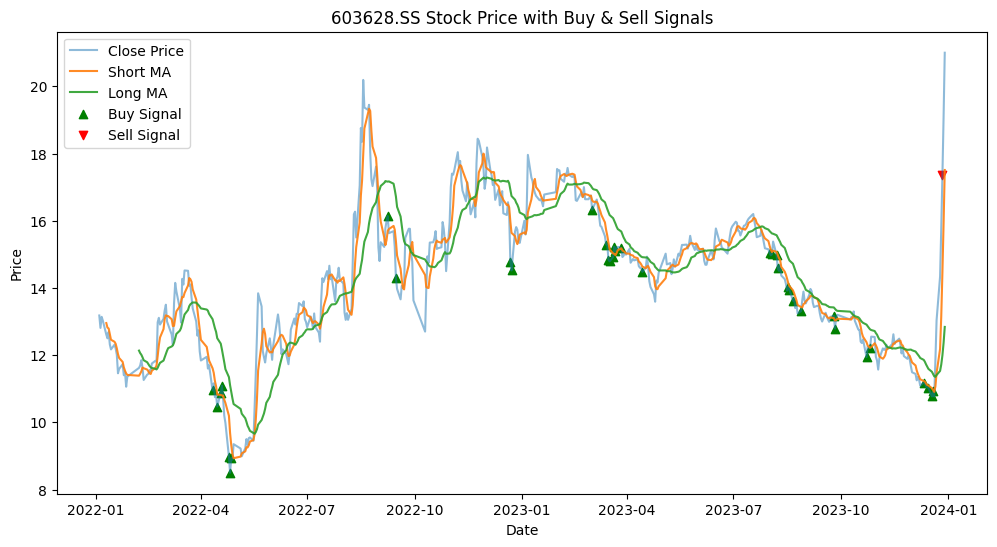

In [112]:

# Define a list of stock tickers
tickers = ['601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ','603628.SS']

start_date = '2022-01-01'
end_date = '2024-01-01'

# Monitor each stock
for ticker in tickers:
    print(f"Analyzing {ticker}...")
    stock = get_stock_data(ticker, start_date, end_date)
    buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal=30, rsi_sell_signal=90)

    # You can store these results in a data structure or database
    print(f"Buy signals for {ticker}:\n", stock[buy])
    print(f"Sell signals for {ticker}:\n", stock[sell])

    # Optional: Plotting
    plt.figure(figsize=(12,6))
    plt.plot(stock['Close'], label='Close Price', alpha=0.5)
    plt.plot(stock['Short_MA'], label='Short MA', alpha=0.9)
    plt.plot(stock['Long_MA'], label='Long MA', alpha=0.9)
    plt.scatter(stock.index[buy], stock['Close'][buy], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(stock.index[sell], stock['Close'][sell], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title(f'{ticker} Stock Price with Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

In [113]:

# Example usage
for ticker in tickers:
  stock = get_stock_data(ticker, start_date, end_date)
  buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal= 40, rsi_sell_signal=90)
  trades, total_return, return_percentage = backtest_strategy(stock, buy, sell,30,0.1)
  print(f"#######################{ticker}##########################")
  print(f"Trades: {trades}")
  print(f"Total Return: ${total_return:.2f}")
  print(f"Return Percentage: {return_percentage:.2f}%")
  print(f"Hold Return Percentage: {(stock['Close'][len(stock)-1]-stock['Close'][0])/stock['Close'][0]*100:.2f}%")


[*********************100%%**********************]  1 of 1 completed


/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/2601323507.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = stock_data['Close'][i]
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/2601323507.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals[i] and balance >= current_price:
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/2601323507.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

#######################601288.SS##########################
Trades: [('BUY', Timestamp('2022-03-04 00:00:00'), 3.0, 333.0), ('BUY', Timestamp('2022-03-07 00:00:00'), 2.9700000286102295, 303.0), ('BUY', Timestamp('2022-03-08 00:00:00'), 2.9700000286102295, 272.0), ('BUY', Timestamp('2022-03-09 00:00:00'), 2.940000057220459, 248.0), ('BUY', Timestamp('2022-03-11 00:00:00'), 2.9700000286102295, 221.0), ('BUY', Timestamp('2022-03-14 00:00:00'), 2.9700000286102295, 198.0), ('BUY', Timestamp('2022-03-15 00:00:00'), 2.930000066757202, 181.0), ('BUY', Timestamp('2022-04-27 00:00:00'), 3.0299999713897705, 158.0), ('BUY', Timestamp('2022-05-17 00:00:00'), 3.0199999809265137, 142.0), ('BUY', Timestamp('2022-05-30 00:00:00'), 3.0199999809265137, 128.0), ('BUY', Timestamp('2022-06-06 00:00:00'), 2.990000009536743, 116.0), ('BUY', Timestamp('2022-06-08 00:00:00'), 2.990000009536743, 105.0), ('BUY', Timestamp('2022-07-14 00:00:00'), 2.950000047683716, 96.0), ('BUY', Timestamp('2022-07-22 00:00:00'), 2


/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/2601323507.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = stock_data['Close'][i]
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/2601323507.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals[i] and balance >= current_price:
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/2601323507.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [12]:
def get_stock_info_on_date(tickers, date=datetime.today().strftime("%Y-%m-%d"), history_days=600, long_term_ma=200, rsi_buy_signal=40, rsi_sell_signal=90):
    print("Today is " + date)
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=history_days)

    market_index = yf.Ticker("^GSPC")  # S&P 500 Index
    market_data = market_index.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    market_signal = get_market_exit_signal(market_data, long_term_ma)
    print(market_signal)

    data = {'Company Code': [], 'Recommendation': [], 'P/E Ratio': [], 'Recommended PE':[], 'Category': [],'Dividend Yield': [], 'Market Cap': [], 'Earnings Growth': []}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        if hist_data.empty:
            continue  # Skip if no data for the given date range

        # Apply buy/sell signal functions (as previously defined)
        buy_signal = check_buy_signal(hist_data,rsi_buy_signal=rsi_buy_signal)
        sell_signal = check_sell_signal(hist_data,rsi_sell_signal=rsi_sell_signal)
        recommendation = 'BUY' if buy_signal else 'SELL' if sell_signal else None

        if recommendation:
            pe_ratio = stock.info.get('trailingPE', 'N/A')
            category = stock.info.get('sector', 'N/A')
            dividend_yield = stock.info.get('dividendYield', 'N/A') * 100 if stock.info.get('dividendYield') is not None else 'N/A'
            market_cap = stock.info.get('marketCap', 'N/A')
            earnings_growth = stock.info.get('earningsGrowth', 'N/A')
            data['Company Code'].append(ticker)
            data['Recommendation'].append(recommendation)
            data['P/E Ratio'].append(pe_ratio)
            data['Category'].append(category)
            data['Dividend Yield'].append(dividend_yield)
            data['Market Cap'].append(market_cap)
            data['Earnings Growth'].append(earnings_growth)
            data['Recommended PE'].append(recommended_pe_ratio(category))

    return pd.DataFrame(data)


In [13]:
def get_sp500_tickers():
    # url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    # sp500_table = pd.read_html(url, header=0)[0]
    # tickers = sp500_table['Symbol'].tolist()
    # print(tickers)
    # return tickers
    return ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEHC', 'GEN', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WRB', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']

sp500_tickers = get_sp500_tickers()

In [14]:
def get_nasdaq_tickers():
    # url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    # tables = pd.read_html(url)  # Scrapes all tables from the Wikipedia page
    # nasdaq_table = tables[4]  # The table with NASDAQ tickers is typically the fourth table on the page
    # nasdaq_tickers = nasdaq_table['Ticker'].tolist()  # Extracts the tickers into a list
    # return nasdaq_tickers
    return ['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']

nasdaq_tickers = get_nasdaq_tickers()
print(nasdaq_tickers)

['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']


# Useless Stock Filter

In [77]:
# Rules
def rule_price_above_moving_averages(stock_data):
    """Price and 50-day MA higher than both 150-day and 200-day MAs."""
    ma50 = stock_data['Close'].rolling(window=50).mean()
    ma150 = stock_data['Close'].rolling(window=150).mean()
    ma200 = stock_data['Close'].rolling(window=200).mean()
    current_price = stock_data['Close'].iloc[-1]
    # print(current_price)
    # print(ma50.iloc[-1])
    # print(ma150.iloc[-1])
    # print(ma200.iloc[-1])
    # print(current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1])
    return current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1]

def rule_ma200_uptrend(stock_data, days=30):
    """200-day MA has been in an uptrend for at least 'days' days."""
    ma200 = stock_data['Close'].rolling(window=200).mean()
    # for every ten days, check if it is still the trend
    for i in range(-1, -days, -10):
        # print(ma200.iloc[-10*i-1],ma200.iloc[-10*i+9])
        if ma200.iloc[-10*i-1] >= ma200.iloc[-10*i+9]:
            return False
    # print(ma200.iloc[-1] > ma200.iloc[-days])
    return True 
    # return ma200.iloc[-1] > ma200.iloc[-days]

def rule_price_above_52week_low(stock_data, threshold=0.25):
    """Current price is at least 'threshold' % higher than the 52-week low."""
    low_52week = stock_data['Close'].rolling(window=252).min().iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    # print(current_price >= low_52week * (1 + threshold))
    return current_price >= low_52week * (1 + threshold)

def rule_price_near_52week_high(stock_data, threshold=0.25):
    """Current price is within 'threshold' % of the 52-week high."""
    high_52week = stock_data['Close'].rolling(window=252).max().iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    # print(current_price >= high_52week * (1 - threshold))
    return current_price >= high_52week * (1 - threshold)

In [45]:
def stock_filter(tickers, rules,date = datetime.today().strftime("%Y-%m-%d")):
    filtered_stocks = []
    for ticker in tickers:
        end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
        min_history_days = 3*365
        start_date = end_date - timedelta(days=min_history_days)
        try:
            data = yf.download(ticker, start=start_date, end=date, progress=False)
            if all(rule(data) for rule in rules):
                filtered_stocks.append(ticker)
            # else:
                # print(ticker + ' is not recommended to trade')
        except:
            continue
    return filtered_stocks

In [84]:
filter_rules = [
    rule_price_above_moving_averages,
    rule_ma200_uptrend,
    rule_price_above_52week_low,
    rule_price_near_52week_high
]

# List of tickers
# tickers = ['AAPL','AMD','ARKK','ARM','BA', 'BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'TMF', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
tickers = nasdaq_tickers
tickers.append(sp500_tickers)
# tickers=['AAPL',"NVDA","TSLA","MSFT","COIN"]
# tickers = ['NVDA']
# Apply the filter
filtered_stocks = stock_filter(tickers, filter_rules)
print("Stocks that meet the criteria:", filtered_stocks)

Failed to get ticker 'BRK.B' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Read timed out. (read timeout=10)

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-17 00:00:00 -> 2024-01-16)')

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-17 00:00:00 -> 2024-01-16)')

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-17 00:00:00 -> 2024-01-16)')

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-17 00:00:00 -> 2024-01-16)')

2 Failed downloads:
['BR

Stocks that meet the criteria: ['ADBE', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AAPL', 'AMAT', 'TEAM', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CTAS', 'CTSH', 'CEG', 'CPRT', 'COST', 'CRWD', 'DDOG', 'DXCM', 'FANG', 'DASH', 'FAST', 'IDXX', 'INTU', 'ISRG', 'KLAC', 'LRCX', 'LULU', 'MAR', 'META', 'MSFT', 'MDB', 'NFLX', 'NVDA', 'NXPI', 'PANW', 'QCOM', 'REGN', 'ROP', 'SNPS', 'VRSK', 'WDAY', 'ZS']


In [86]:
def test_stock_filter_performance(tickers, rules, start_date, end_date):
    passed_stocks = stock_filter(tickers, rules, start_date)
    failed_stocks = set(tickers) - set(passed_stocks)

    return calculate_average_return(passed_stocks, start_date, end_date), calculate_average_return(failed_stocks, start_date, end_date), passed_stocks, failed_stocks

def calculate_average_return(stocks, start_date, end_date):
    returns = []
    annualized_returns = []
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    days_in_period = (end - start).days
    for ticker in stocks:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if not stock_data.empty:
                initial_price = stock_data['Close'].iloc[0]
                final_price = stock_data['Close'].iloc[-1]
                stock_return = (final_price - initial_price) / initial_price
                annualized_return = (1 + stock_return) ** (365.0 / days_in_period) - 1
                returns.append(stock_return)
                annualized_returns.append(annualized_return)
        except:
            continue
    if returns:
        return sum(returns) / len(returns), sum(annualized_returns)/len(annualized_returns)
    else:
        # need a better solution
        return 0, 0

# Example usage
tickers = sp500_tickers
start_date = "2023-01-01"
end_date = '2023-12-01'

average_return_passed, average_return_failed, passed_stocks, failed_stocks = test_stock_filter_performance(tickers, filter_rules, start_date, end_date)
print("Average yearly Return of Passed Stocks:", average_return_passed[1], "Number of Passed Stocks: ", len(passed_stocks))
print(passed_stocks)
print("Average yearly Return of Failed Stocks:", average_return_failed[1], "Number of Failed Stocks: ", len(failed_stocks))


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-03 00:00:00 -> 2023-01-01)')

1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1578027600, endDate = 1672549200")

1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1578027600, endDate = 1672549200")

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-12-01)')


Average yearly Return of Passed Stocks: 0.13290631463930863 Number of Passed Stocks:  64
['AES', 'A', 'APD', 'AMP', 'AME', 'ADM', 'ANET', 'AJG', 'AZO', 'AXON', 'BLK', 'BLDR', 'CAT', 'COR', 'CI', 'CTAS', 'CAG', 'CSGP', 'CMI', 'DE', 'DXCM', 'DG', 'DHI', 'DD', 'ETN', 'LLY', 'FICO', 'FSLR', 'GIS', 'HON', 'HUBB', 'HUM', 'IEX', 'ITW', 'IR', 'PODD', 'JCI', 'KEYS', 'KLAC', 'LEN', 'LKQ', 'MCK', 'MTD', 'MCHP', 'MOH', 'MNST', 'NDAQ', 'NVR', 'ORLY', 'ORCL', 'PCAR', 'PGR', 'PWR', 'DGX', 'REGN', 'SJM', 'SBUX', 'STLD', 'SYK', 'TSCO', 'TT', 'URI', 'GWW', 'XYL']
Average yearly Return of Failed Stocks: 0.09210445603197125 Number of Failed Stocks:  439


In [90]:

def closest_trading_date(data, date):
    """Find the closest previous trading date in the data for a given date."""
    if date in data.index:
        return date
    # Iterate backwards to find the closest previous date
    while date not in data.index:
        date -= pd.Timedelta(days=1)
    return date

def test_filter_performance_over_periods(tickers, rules, start_date, end_date):
  
    # Generate dates at regular intervals between start and end
    date_range = pd.date_range(start=start_date, end=end_date, freq='M')
    filtered_stocks = stock_filter(tickers, rules, start_date)
    unfiltered_stocks = set(tickers) - set(filtered_stocks)

    # Lists to store results
    filtered_returns = []
    unfiltered_returns = []
    differences = []
    sp500_returns = []

    sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
    
    for date in date_range:
        trading_date = closest_trading_date(sp500, date)

        filtered_avg_return, _ = calculate_average_return(filtered_stocks, start_date, date.strftime('%Y-%m-%d'))
        unfiltered_avg_return, _ = calculate_average_return(unfiltered_stocks, start_date, date.strftime('%Y-%m-%d'))

        sp500_return = (sp500.loc[trading_date] - sp500[0]) / sp500[0]

        filtered_returns.append(filtered_avg_return if filtered_avg_return is not None else 0)
        unfiltered_returns.append(unfiltered_avg_return if unfiltered_avg_return is not None else 0)
        differences.append((filtered_avg_return - unfiltered_avg_return) if filtered_avg_return is not None and unfiltered_avg_return is not None else 0)
        sp500_returns.append(sp500_return)

    return date_range, filtered_returns, unfiltered_returns, differences, sp500_returns


start_date = '2022-05-01'
end_date = '2024-01-01'
tickers = nasdaq_tickers[30:70]
date_range, filtered_returns, unfiltered_returns, differences, sp500_returns = test_filter_performance_over_periods(tickers, filter_rules, start_date, end_date)



1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1556856000, endDate = 1651377600")

1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1651377600, endDate = 1653969600")
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/629837805.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sp500_return = (sp500.loc[trading_date] - sp500[0]) / sp500[0]

1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1651377600, endDate = 1656561600")
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_43858/629837805.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

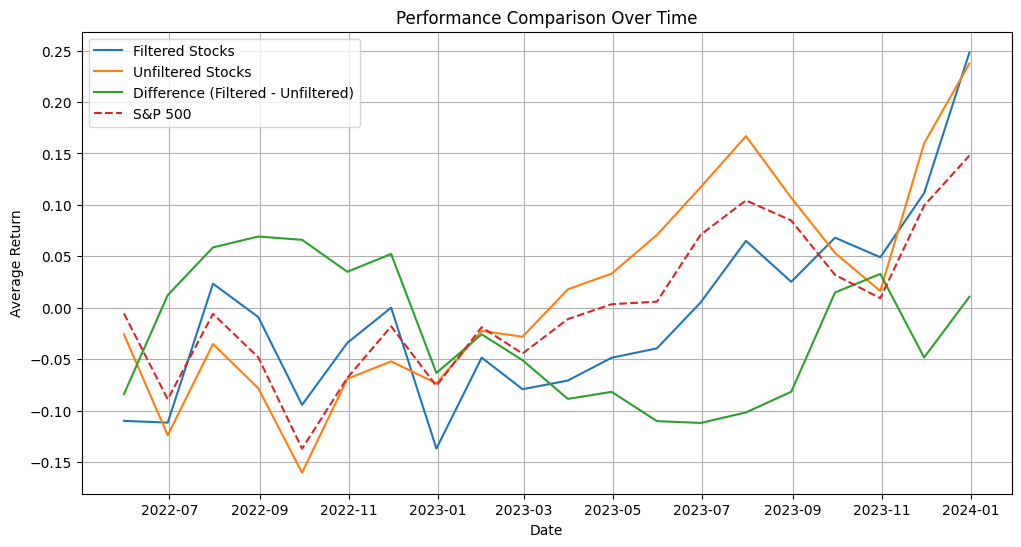

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(date_range, filtered_returns, label='Filtered Stocks')
plt.plot(date_range, unfiltered_returns, label='Unfiltered Stocks')
plt.plot(date_range, differences, label='Difference (Filtered - Unfiltered)')
plt.plot(date_range, sp500_returns, label='S&P 500', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.title('Performance Comparison Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Stock Warning

In [21]:
def rule_price_increase(stock_data):
    """Rule 2: 25-50% increase in 1 to 3 weeks."""
    period_returns = stock_data['Close'].pct_change(periods=5).iloc[-1]  # 1-week return
    return 0.25 <= period_returns <= 0.50

def rule_largest_gain(stock_data):
    """Rule 3: Largest single-day gain since rise began."""
    daily_gains = stock_data['Close'].pct_change()
    max_gain = daily_gains.max()
    recent_gain = daily_gains.iloc[-1]
    return recent_gain == max_gain

def rule_accelerating_growth(stock_data):
    """Rule 6: 6-10 days of accelerating growth, with only about 2 days of decline."""
    recent_data = stock_data['Close'].iloc[-10:]
    up_days = recent_data.pct_change() > 0
    return up_days.sum() >= 8

def rule_falling_below_ma(stock_data):
    """Rule 10: Falling below 50-day MA on largest volume."""
    ma50 = stock_data['Close'].rolling(window=50).mean().iloc[-1]
    max_volume = stock_data['Volume'].max()
    recent_volume = stock_data['Volume'].iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    return current_price < ma50 and recent_volume == max_volume

In [22]:
def stock_warning_system(tickers, date, rules):
    warnings = {}
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=365)
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=date)
        for rule in rules:
            if rule(data):
                warnings.setdefault(ticker, []).append(rule.__name__)
    return warnings

In [23]:
# Define your rules
warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]  # Add other rule functions here

# List of tickers and a specific date
# tickers = ['AAPL', 'MSFT', 'GOOG']
tickers = nasdaq_tickers
date = '2024-01-03'  # Replace with your date

# Get warnings 
warnings = stock_warning_system(tickers, date, warning_rules)
print("Warnings:", warnings)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'MRNA': ['rule_largest_gain'], 'MNST': ['rule_accelerating_growth']}


# Everyday

In [114]:
# Example usage
# tickers = get_nasdaq_tickers() # List of tickers
# tickers = get_sp500_tickers()
date = datetime.today().strftime("%Y-%m-%d")
# date = '2024-01-06'
cn_tickers = ['601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ','603628.SS']
tickers = ['AAPL','AMD', 'ABNB','ALK', 'ARKK','ARM','BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
tickers = tickers + cn_tickers
print(tickers)
stock_table = get_stock_info_on_date(tickers, date,rsi_buy_signal=20,rsi_sell_signal=90)


warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]
warnings = stock_warning_system(tickers, date, warning_rules)
print("Warnings:", warnings)


# Set the display.max_rows option to None
pd.set_option('display.max_rows', None)
display(stock_table)

['AAPL', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'BABA', 'BAC', 'BILI', 'BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB', 'META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'WFC', 'XOM', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS']
Today is 2024-01-19
Stay


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'COST': ['rule_accelerating_growth'], 'DDOG': ['rule_accelerating_growth'], 'SAVE': ['rule_falling_below_ma']}


,Company Code,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth
0,ARKK,BUY,N/A,"(N/A, N/A)",N/A,N/A,N/A,N/A
1,COIN,BUY,N/A,"(N/A, N/A)",Financial Services,N/A,29845938176,N/A
2,SAVE,BUY,N/A,"(15, 25)",Industrials,N/A,729242240,N/A
3,TRV,SELL,22.85853,"(N/A, N/A)",Financial Services,2.02,48345219072,-0.079
